<a href="https://colab.research.google.com/github/Kavya-sree/Hair-Type-Classifier/blob/main/Hair_type_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import fastai
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback

import albumentations as A


In [26]:
# Define data path 
path = Path('data')

# Set the model directory outside the data folder
model_dir = Path('./models')  

# Ensure the directory exists
model_dir.mkdir(parents=True, exist_ok=True)  

## Data Augmentations using Albumentations

In [27]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx, order = None, 2

    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

def get_train_aug(sz):
    return A.Compose([
        A.RandomResizedCrop(sz, sz),
        A.Transpose(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.CoarseDropout(p=0.5),
    ])

def get_valid_aug(sz):
    return A.Compose([
        A.Resize(sz, sz)
    ], p=1.)


## Data Loader
DataLoaders: A fastai class that stores multiple DataLoader objects you pass to it, normally a train and a valid, although it's possible to have as many as you like. The first two are made available as properties.

In [28]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

With `DataBlock` API you can fully customize every stage of the creation of your `DataLoaders`.

In [29]:
def get_dls(path, sz, bs):
    item_tfms = AlbumentationsTransform(get_train_aug(sz), get_valid_aug(sz))
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    
    dls = ImageDataLoaders.from_folder(
        path,         # Path to your folder containing class subfolders
        valid_pct=0.2, # Split 20% for validation
        seed=42,       # Random seed
        item_tfms=item_tfms, # Apply Albumentations transforms
        batch_tfms=batch_tfms, # Normalization
        bs=bs          # Batch size
    )
    return dls

# Get DataLoaders
dls = get_dls(path, sz=224, bs=64)

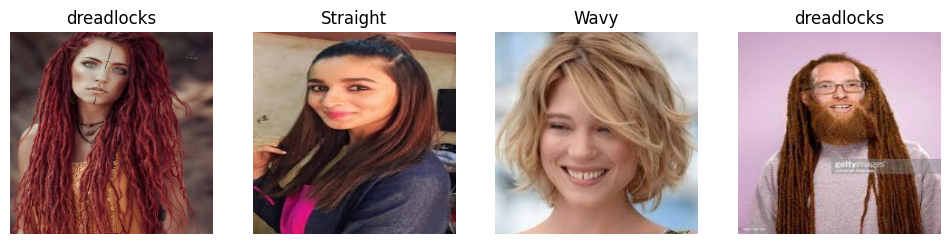

In [30]:
dls.valid.show_batch(max_n=4, nrows=1)

# Modelling

We don't have a lot of data for our problem, so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms:

In [31]:
#learn = vision_learner(dls, resnet18, metrics=error_rate)
learn = vision_learner(dls, resnet18, metrics=error_rate, wd=1e-2, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=2), SaveModelCallback(monitor='valid_loss')])

learn.model_dir = model_dir.absolute()
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.907831,0.960150,0.324937,01:34


Better model found at epoch 0 with valid_loss value: 0.9601499438285828.


/home/kavya/Hair-Type-Classifier/venv/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=

epoch,train_loss,valid_loss,error_rate,time
0,1.153393,0.788821,0.274559,00:29
1,1.112423,0.648360,0.249370,00:16
2,1.021699,0.541624,0.204030,00:39
3,0.912447,0.499706,0.186398,00:19
4,0.819857,0.453189,0.146096,00:16
5,0.734474,0.375558,0.138539,00:11
6,0.683471,0.370653,0.141058,00:11
7,0.648311,0.352101,0.133501,00:10
8,0.620325,0.340015,0.118388,00:10
9,0.608415,0.343144,0.136020,00:11


Better model found at epoch 0 with valid_loss value: 0.788820743560791.
Better model found at epoch 1 with valid_loss value: 0.6483600735664368.
Better model found at epoch 2 with valid_loss value: 0.5416235327720642.
Better model found at epoch 3 with valid_loss value: 0.49970608949661255.
Better model found at epoch 4 with valid_loss value: 0.45318856835365295.
Better model found at epoch 5 with valid_loss value: 0.37555843591690063.
Better model found at epoch 6 with valid_loss value: 0.370652973651886.
Better model found at epoch 7 with valid_loss value: 0.35210147500038147.
Better model found at epoch 8 with valid_loss value: 0.340015172958374.


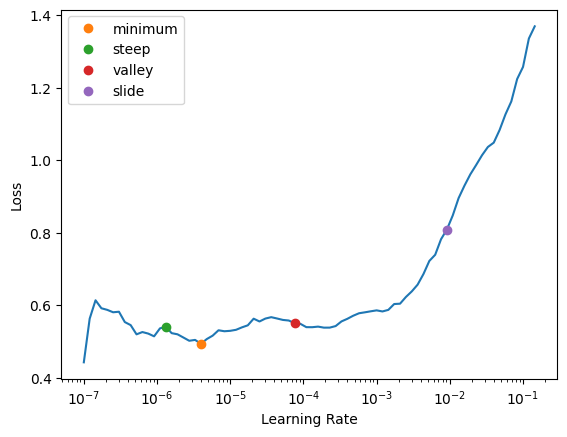

In [32]:
learn.save('stage-1')
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [33]:
learn.fit_one_cycle(10, lrs.valley)

epoch,train_loss,valid_loss,error_rate,time
0,0.598730,0.338439,0.118388,00:11
1,0.580354,0.326856,0.118388,00:10
2,0.555966,0.351706,0.138539,00:42
3,0.551526,0.349961,0.128463,00:11


Better model found at epoch 0 with valid_loss value: 0.3384391963481903.
Better model found at epoch 1 with valid_loss value: 0.32685616612434387.
No improvement since epoch 1: early stopping


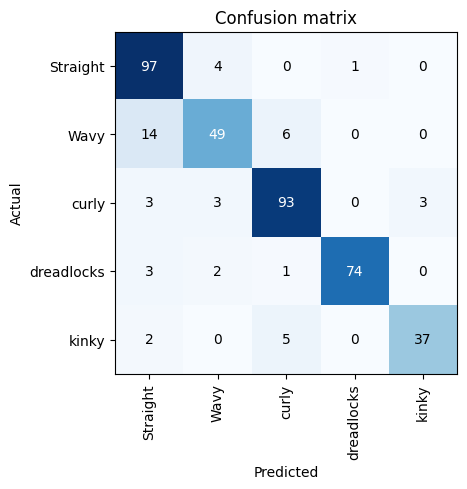

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

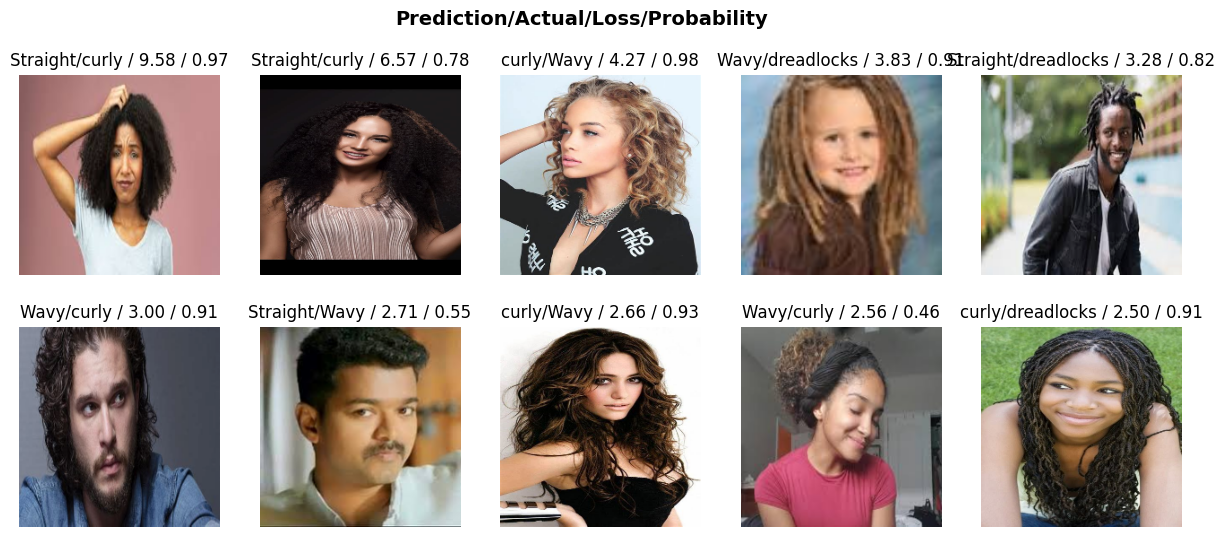

In [35]:
interp.plot_top_losses(10, nrows=2)

In [37]:
from sklearn.metrics import classification_report

# Get the predictions and actual values for the validation set
def print_classification_report(learn):
    # Get predictions and true labels
    preds, targs = learn.get_preds(dl=learn.dls.valid)
    
    # Convert predictions to class indices
    pred_classes = preds.argmax(dim=1)
    
    # Get the list of class labels from the dataloaders
    class_names = learn.dls.vocab
    
    # Print classification report
    print(classification_report(targs, pred_classes, target_names=class_names))

# Call the function after loading your model or after training
print_classification_report(learn)


              precision    recall  f1-score   support

    Straight       0.82      0.95      0.88       102
        Wavy       0.84      0.71      0.77        69
       curly       0.89      0.91      0.90       102
  dreadlocks       0.99      0.93      0.95        80
       kinky       0.93      0.84      0.88        44

    accuracy                           0.88       397
   macro avg       0.89      0.87      0.88       397
weighted avg       0.89      0.88      0.88       397



In [36]:
learn.path = model_dir
learn.export('hair-resnet18-model.pkl')